In [69]:
import sys
print(sys.version)

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [2]:
# wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=14UBHX6GTW_4YiyjNJB3EEq7Xb83AjuaK' -O process_mining_datasets.zip

import pandas as pd
# pd.set_option("max_columns", 200)
import numpy as np
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

# Meus pacotes
import parse_mxml as pm
import log_representation as lr
import plots as plts
import model_utils as mu
import drift_detection as dd
import offline_streaming_clustering as off_sc

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 
import traceback 

from copy import deepcopy
import random
random.seed(42)
import os
import re
import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.cluster import KMeans, AgglomerativeClustering

import gc
gc.enable()

# # # # # # # # # # #
# LOAN APPLICATIONS #
# # # # # # # # # # #
aliases = {
    'Loan__application_received': 'START',
    'Appraise_property': 'A',
    'Approve_application': 'B',
    'Assess_eligibility': 'C',
    'Assess_loan_risk': 'D',
    'Cancel_application': 'E',
    'Check__application__form_completeness': 'F',
    'Check_credit_history': 'G',
    'Check_if_home_insurance_quote_is_requested': 'H',
    'Prepare_acceptance_pack': 'I',
    'Receive_updated_application': 'J',
    'Reject_application': 'K',
    'Return_application_back_to_applicant': 'L',
    'Send_acceptance_pack': 'M',
    'Send_home_insurance_quote': 'N',
    'Verify_repayment_agreement': 'O',
    'Loan__application_approved': 'END_A',
    'Loan_application_rejected': 'END_R',
    'Loan__application_canceled': 'END_C',
}

inv_aliases = {v: k for k, v in aliases.items()}

In [3]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

In [4]:
logs = insensitive_glob("../process_mining_datasets/*/*k.MXML")

In [5]:
logs = [x for x in logs if "2.5" not in x]

In [6]:
objects = {
    "model": {
        "kmeans__k=8": KMeans(n_clusters=8, random_state=42, n_jobs=6),
        "kmeans__k=6": KMeans(n_clusters=6, random_state=42, n_jobs=6),
        "kmeans__k=3": KMeans(n_clusters=3, random_state=42, n_jobs=3),
        "agglomerative__k=8_linkage=ward": AgglomerativeClustering(n_clusters=8, linkage='ward'),
        "agglomerative__k=6_linkage=ward": AgglomerativeClustering(n_clusters=6, linkage='ward'),
        "agglomerative__k=3_linkage=ward": AgglomerativeClustering(n_clusters=3, linkage='ward'),
    },
    
    "representation": {
        "binary": lambda x: lr.get_binary_representation(lr.get_traces_as_tokens(x)),
        "frequency": lambda x: lr.get_frequency_representation(lr.get_traces_as_tokens(x)),
        "tfidf": lambda x: lr.get_tfidf_representation(lr.get_traces_as_tokens(x)),
        "transitions": lambda x: lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)),
        #"positions": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x)),
        #"positions_min_max": lambda x: lr.get_min_max_positions_representation(lr.get_traces_as_tokens(x)),
        #"positions_avg": lambda x: lr.get_positions_representation(lr.get_traces_as_tokens(x), include_cols=["_avg"]),
    }
}

In [7]:
config = {
    "log": [x for x in logs if "2.5" not in x],
    "representation": ['binary', 'frequency', 'tfidf', 'transitions'],
    "sliding_window": [False, True],
    "window_size": [50, 100, 150, 200, 250, 300],
    "model": [
        'kmeans__k=8', 'agglomerative__k=8_linkage=ward',
        'kmeans__k=6', 'agglomerative__k=6_linkage=ward',
        'kmeans__k=3', 'agglomerative__k=3_linkage=ward'
    ]
}

In [8]:
from sklearn.model_selection import ParameterGrid
combinations = list(ParameterGrid(config))
len(combinations)

15552

In [23]:
def run_pipeline(args):
    try:
        r = {}
        
        # Tratamento do caminho do arquivo para estruturar nomes
        # e tamanho do log
        split = args["log"].split("/")

        cd_name = split[2]
        log_name = split[3][:-5]

        log_size = log_name.replace(cd_name, "")
        log_size = int(float(log_size.replace("k", "")) * 1000)

        # Monta o vetor de resposta
        y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]

        # String para identificação da memória cache
        cached_info = "_".join([
            log_name, str(log_size), args["model"], args["representation"], str(args["window_size"]), str(args["sliding_window"])
        ])

        # print(cached_info, end="\r")
        
        # Lê o log e aplica a representação
        log_read = pm.all_prep(args["log"], aliases)
        df = objects["representation"][args["representation"]](
            log_read
        )


        run_df, measures_df = off_sc.run_offline_clustering_window(
            sk_clone(objects["model"][args["model"]]),
            args["window_size"],
            df,
            args["sliding_window"]
        )

        all_metrics = run_df.join(measures_df)
        
        dir_name = "../offline_window_clustering_results_v2/" + cd_name + "/"
        try:
            os.makedirs(dir_name)
        except:
            pass
        
        all_metrics.to_csv(dir_name + cached_info + ".csv")
        
        test = pd.read_csv(dir_name + cached_info + ".csv", index_col=0)
        assert test.shape == all_metrics.shape

    except Exception as e:
        traceback.print_exc()

In [24]:
args = combinations[0]

In [31]:
run_pipeline(combinations[0])

In [32]:
from joblib import Parallel, delayed, parallel_backend
from tqdm import tqdm

In [33]:
final_resp = Parallel(n_jobs=42)(
    delayed(run_pipeline)(comb) for comb in tqdm(combinations)
)

100%|██████████| 15552/15552 [1:08:27<00:00,  3.79it/s]


In [43]:
test = pd.read_csv("../offline_window_clustering_results_v2/sw/sw7.5k_7500_kmeans__k=6_transitions_200_False.csv", index_col=0)

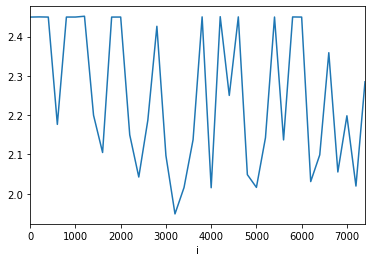

In [45]:
test.min_dist_between_centroids.plot()

In [39]:
test.head()

,k,Silhouette,DBi,centroids,avg_dist_between_centroids,std_dist_between_centroids,min_dist_between_centroids,max_dist_between_centroids,radius_list,dist_intra_cluster_list,...,avg_MSE,count_non_zero_MSE,diff_avg_dist_between_centroids,diff_std_dist_between_centroids,diff_min_dist_between_centroids,diff_max_dist_between_centroids,diff_radius,diff_dist_intra_cluster,diff_skewness,diff_cluster_std
i,,,,,,,,,,,,,,,,,,,,,
0,5,0.658021,0.954659,[[0. 0. 1. 0. ...,2.878804,0.492355,2.449497,3.490202,"[1.6184737054332132, 1.612599027736541, 1.4308...","[0.21579649405776175, 0.23037128967664872, 0.5...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,5,0.665691,0.966741,[[0. 0. 1. 0. ...,2.866428,0.494579,2.449921,3.478778,"[1.637575308974211, 1.591614255603833, 1.44337...","[0.1819528121082457, 0.2652690426006389, 0.502...",...,0.063385,17.0,-0.012376,0.002224,0.000424,-0.011424,0.016659,0.003260,0.000232,1.118234e-06
100,5,0.660356,0.901783,[[0. 1. 0. 0. ...,2.892132,0.489058,2.449955,3.514188,"[1.6779242198323499, 1.6301654659471785, 1.495...","[0.10825317547305481, 0.1956198559136614, 0.42...",...,0.160388,20.0,0.025704,-0.005521,0.000034,0.035410,0.002513,0.011557,0.000143,1.253959e-06
150,5,0.659151,0.907638,[[0. 1. 0. 0. ...,2.875152,0.495404,2.449969,3.503095,"[1.6723249176527093, 1.6037507477489605, 1.555...","[0.11945177983233636, 0.24673088426907083, 0.3...",...,0.129918,17.0,-0.016980,0.006346,0.000013,-0.011093,0.005803,0.006725,0.000258,1.626531e-06
200,5,0.628475,0.925908,[[0. 1. 0. 0. ...,2.865954,0.496146,2.449926,3.483963,"[1.6743157806499147, 1.5814376938672359, 1.535...","[0.11547005383792515, 0.28753412615767926, 0.3...",...,0.095859,20.0,-0.009198,0.000742,-0.000043,-0.019132,0.003014,0.007782,0.000069,4.102704e-07


## Drift

In [ ]:
drift_config = [
#     {
#         "input": insensitive_glob("../offline_window_clustering_results_v2/*/*.csv"),
#         "detection_type": ["tradicional"],
#         "rolling_window": [2, 5],
#         "std_tolerance": [1.25, 1.5, 1.75, 2, 2.25],
#     },
    {
        "input": insensitive_glob("../offline_window_clustering_results_v2/*/*.csv"),
        "detection_type": ["cumulative"],
        "rolling_window": [3, 4],
        "std_tolerance": [1.25, 1.5, 1.75, 2, 2.25],
        "smooth_factor": [0.2, 0.4, 0.6, 0.8]
    },
#     {
#         "input": os.listdir("../offline_window_clustering_results"),
#         "detection_type": ["exponential", "cumulative"],
#         "rolling_window": [3, 4],
#         "std_tolerance": [1.25, 1.5, 1.75, 2, 2.25],
#         "smooth_factor": [0.2, 0.4, 0.6, 0.8]
#     }
]

In [71]:
def my_split(s):
    return list(filter(None, re.split(r'(\d+)', s)))

def parse_name_info(name):
    return {
        "tipo_mudanca": my_split(name[0])[0],
        "log_size": int(name[1]),
        "representation": name[-3],
        "window_size": int(name[-2]),
        "model": "_".join(name[2:-3]),
        "sliding_window": name[-1].split(".")[0]
    }

In [72]:
parse_name_info(drift_config[0]["input"][1].split("/")[-1].split("_"))

{'tipo_mudanca': 'RIO',
 'log_size': 7500,
 'representation': 'frequency',
 'window_size': 250,
 'model': 'kmeans__k=3',
 'sliding_window': 'True'}

In [73]:
from sklearn.model_selection import ParameterGrid
combinations = list(ParameterGrid(drift_config))
len(combinations)

155520

In [74]:
def drift_detect_pipeline(args):
    all_metrics = pd.read_csv(args["input"], index_col=0)
    
    info = parse_name_info(args["input"].split("/")[-1].split("_"))
    # print(info)
    # Monta o vetor de resposta
    y_true = [x for x in range(int(info["log_size"]/10), info["log_size"], int(info["log_size"]/10))]
    
    results = []
    for col in all_metrics.select_dtypes(include=np.number).columns:
        if (col not in ["k"] and not col.startswith("diff") ) or col in ["diff_centroids"]:
            r = deepcopy(info)
            r["measure"] = col

            # print(col)
            # print(all_metrics[col].dtype)

            if args["detection_type"] == "tradicional":
                detected_drifts, extra = dd.detect_concept_drift(
                    all_metrics, 
                    col,
                    args["rolling_window"],
                    args["std_tolerance"]
                )

            if args["detection_type"] == "cumulative":
                detected_drifts, extra = dd.cumulative_detect_concept_drift(
                    all_metrics, 
                    col,
                    args["rolling_window"],
                    args["std_tolerance"]
                )


            if args["detection_type"] == "exponential":
                detected_drifts, extra = dd.exponential_smooth_detect_concept_drift(
                    all_metrics,
                    col,
                    args["rolling_window"],
                    args["std_tolerance"],
                    args["smooth_factor"]
                )


            metrics_results = dd.get_metrics(
                detected_drifts,
                y_true,
                info["window_size"]
            )


            r.update(args)
            r.update(metrics_results)

            results.append(r)

            gc.collect()
    
    
    to_string = [args["detection_type"], str(args["rolling_window"]), str(args["std_tolerance"]).replace(".", "-")]
    if "smooth_factor" in args:
        to_string += [str(args["smooth_factor"]).replace(".", "-")]
    
    base_name = args["input"].replace(".csv", "")
    base_name = base_name.replace("offline_window_clustering_results_v2", "drift_detection_results_v2")
    
    try:
        os.makedirs(base_name)
    except:
        pass
    
    pd.DataFrame(results).to_csv(
        base_name + "/" + "_".join(to_string) + ".csv",
        sep=";"
    )
    # print(col, len(results))

In [75]:
drift_detect_pipeline(combinations[0])

In [ ]:
final_resp = Parallel(n_jobs=46)(
    delayed(drift_detect_pipeline)(comb) for comb in tqdm(combinations)
)

 41%|████      | 63710/155520 [41:06<57:01, 26.83it/s]  

In [22]:

import traceback
traceback.print_last()

joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 418, in _process_worker
    r = call_item()
  File "/home/ubuntu/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 272, in __call__
    return self.fn(*self.args, **self.kwargs)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 608, in __call__
    return self.func(*args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.6/site-packages/joblib/parallel.py", line 256, in __call__
    for func, args, kwargs in self.items]
  File "/home/ubuntu/.local/lib/python3.6/site-packages/joblib/parallel.py", line 256, in <listcomp>
    for func, args, kwargs in self.items]
  File "<ipython-input-17-4fc0d33e3375>", line 48, in drift_detect_pipeline
  File "/home/ubuntu/.jupyter/experimentos_mestrado/drift_detection.py", line 4